### Import dataset

In [1]:
data <- read.csv("~/Documents/jupyter-workplace/laser-anoxia/microglia-morphology/data-processing/_m/features_data.csv")
head(data)

Animal,Corte,Grupo,Region,Foreground.pixels.by.hull.area,Hull.Area,Diameter.of.Bounding.Circle,Mean.Radius,Cell.Area,Cell.Perimeter,...,Hull.void.area,Branches,Junctions,End.point.voxels,Triple.points,Quadruple.points,Average.branch.length,Maximum.branch.length,D,Lacunarity
CS2,1,CS,CA1,0.5968,2282,74.9667,31.5814,1362,344.416,...,920,15,7,9,7,0,13.283,29.556,1140,801
CS2,1,CS,CA1,0.8191,376,32.8571,14.7844,308,91.983,...,68,3,1,3,1,0,13.876,22.142,41,1246
CS2,1,CS,CA1,0.4057,2036,78.4092,32.8051,826,246.635,...,1210,7,3,5,3,0,17.840,34.627,87,1271
CS2,1,CS,CA1,0.4576,2380,69.3097,30.9999,1089,341.061,...,1291,20,11,7,11,0,10.674,27.385,429,1659
CS2,1,CS,CA1,0.4241,2457,70.9627,32.7330,1042,371.588,...,1415,18,9,9,9,0,12.222,20.071,585,1452
CS2,1,CS,CA1,0.2993,5362,119.4364,50.7948,1605,709.720,...,3757,40,19,20,17,1,10.588,31.799,538,1596


In [2]:
# silence function
shhh <- function(x){
    suppressPackageStartupMessages(suppressWarnings(x))
    }

# multiplot from cookbook-r
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)
  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

## Clustering with optimun configuration

k = 3
Circularity
Endpoints
Hull Area
Cell Perimeter

In [3]:
shhh(library(tidyverse))

# filter data
id.data       <- data[,1:4]
variable.data <- data %>% select(Circularity,End.point.voxels,Hull.Area,Cell.Perimeter)

# pca
pca.data <- prcomp(variable.data, center = TRUE, scale = TRUE)
pca.x    <- pca.data$x[,1:2]

# clustering
clust.data <- hclust(dist(pca.x,method = "euclidian"), method = "ward.D2")
clust.id   <- as.factor(cutree(clust.data,k=3))

In [35]:
head(data[,1:4])

Animal,Corte,Grupo,Region
CS2,1,CS,CA1
CS2,1,CS,CA1
CS2,1,CS,CA1
CS2,1,CS,CA1
CS2,1,CS,CA1
CS2,1,CS,CA1


In [36]:
# pca coordinates + cluster id
pca_x.plus.id <- cbind(data[,1:4],pca.x, cluster = clust.id)

write_csv(x = as.data.frame(pca_x.plus.id), path = "/home/caio/Documents/jupyter-workplace/laser-anoxia/microglia-morphology/data-processing/unsupervised-ml-analysis/_m/pca-xplusid.csv")

# head(pca_x.plus.id)

#### Dendrogram

Warning message in `labels<-.dendrogram`(dend, value = value, ...):
“The lengths of the new labels is shorter than the number of leaves in the dendrogram - labels are recycled.”Warning message in rep(new_labels, length.out = leaves_length):
“'x' is NULL so the result will be NULL”

integer(0)

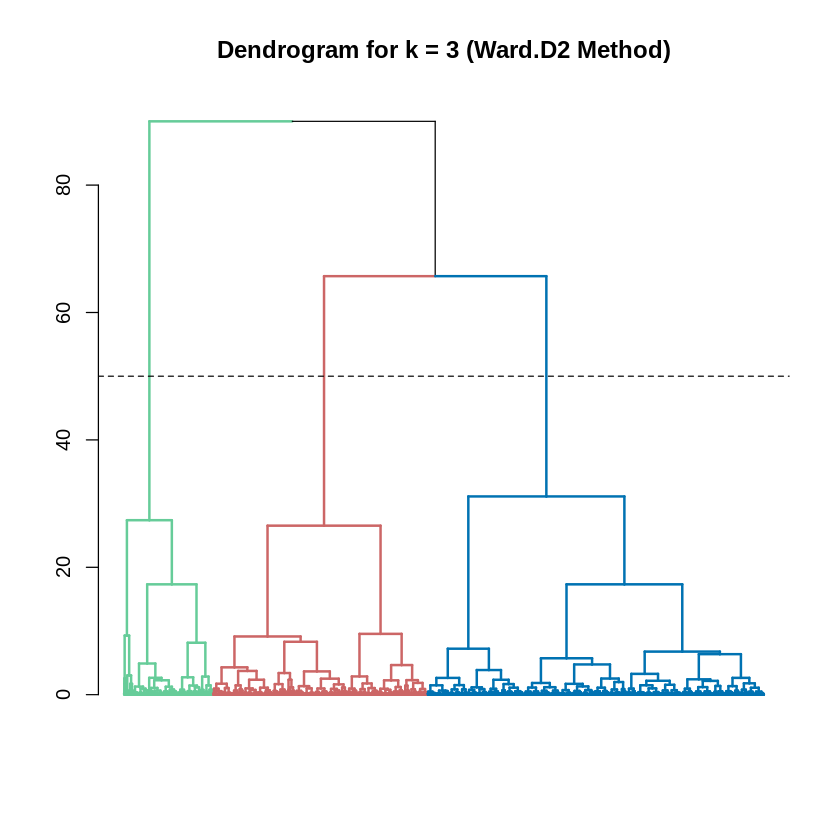

In [4]:
shhh(library(dendextend))

colbranches <- function(n, col){
  a <- attributes(n) # Find the attributes of current node
  # Color edges with requested color
  attr(n, "edgePar") <- c(a$edgePar, list(col=col, lwd=2))
  n # Don't forget to return the node!
  }

title <- "Dendrogram for k = 3 (Ward.D2 Method)"

dend <- clust.data %>%  
  as.dendrogram() %>% set("labels", NULL)

dend[[1]] = dendrapply(dend[[1]], colbranches, "#66CC99")
dend[[2]][[1]] = dendrapply(dend[[2]][[1]], colbranches, "#CC6666")
dend[[2]][[2]] = dendrapply(dend[[2]][[2]], colbranches, "#0072B2")

#plot(dend, main = title)
plot(dend, main = title, type = "rectangle") + abline(h = 50, lty = 2)

rm(title)

#### PCA

In [5]:
# had some problems installing the package so I called the function manualy
source("ggbiplot.R")

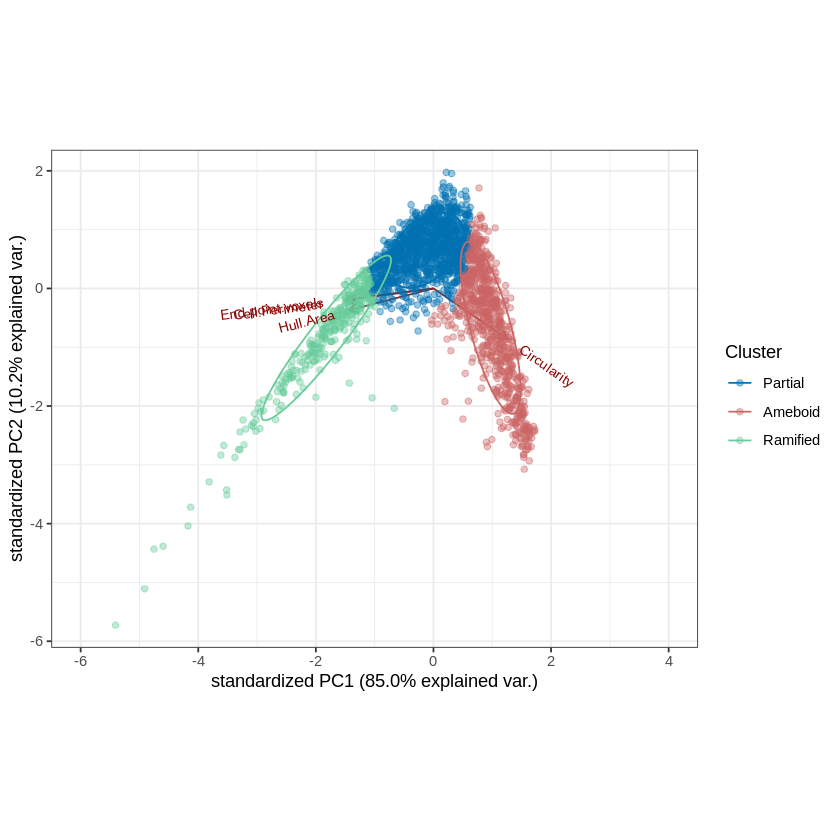

In [19]:
library(svglite)

p <- shhh(ggbiplot(pca.data, choices = 1:2, alpha = 0.4, ellipse = TRUE, 
groups = clust.id) + scale_color_manual(name="Cluster", 
values=c("#0072B2","#CC6666","#66CC99"), labels = c("Partial","Ameboid","Ramified")) +
theme(legend.direction ="horizontal", legend.position = "top") +
xlim(c(-6,4))) + theme_bw()

p

# export plot as SVG
ggsave(file="pca-svg.svg", plot=p, width=9, height=7)

#### Counting cluster

In [7]:
# construir um 'data' com a classificação por celula
cluster <- data.frame(Cluster = clust.id)
data.cluster <- as.data.frame(c(data[,1:4],cluster,data[,5:23]))

# soma de celulas/cluster
reduced.data.cluster <- data.cluster[,1:5]

summary.cluster.all    <- reduced.data.cluster %>% 
                            group_by(Grupo,Animal,Cluster) %>% 
                            dplyr::summarise(Number.per.cluster = n())
summary.cluster.region <- reduced.data.cluster %>% 
                            group_by(Grupo,Animal,Region,Cluster) %>% 
                            dplyr::summarise(Number.per.cluster = n())

summary.cluster.CA3    <- filter(summary.cluster.region, Region == "CA3")

# filtrar celulas de fora do hipocampo em CA3
id.to.remove.ca3 <- read.csv("~/Documents/jupyter-workplace/laser-anoxia/microglia-morphology/data-processing/_m/id-to-remove-ca3.csv")

f.reduced.data.cluster <- reduced.data.cluster[-id.to.remove.ca3$id,]

f.summary.cluster.CA3 <- f.reduced.data.cluster %>% 
                            filter(Region == "CA3") %>%
                            group_by(Grupo,Animal,Region,Cluster) %>% 
                            dplyr::summarise(Number.per.cluster = n())

# write.csv(f.summary.cluster.CA3,"filtered-cluster-ca3.csv")

`summarise()` has grouped output by 'Grupo', 'Animal'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Grupo', 'Animal', 'Region'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Grupo', 'Animal', 'Region'. You can override using the `.groups` argument.


#### Plot cluster by experimental group

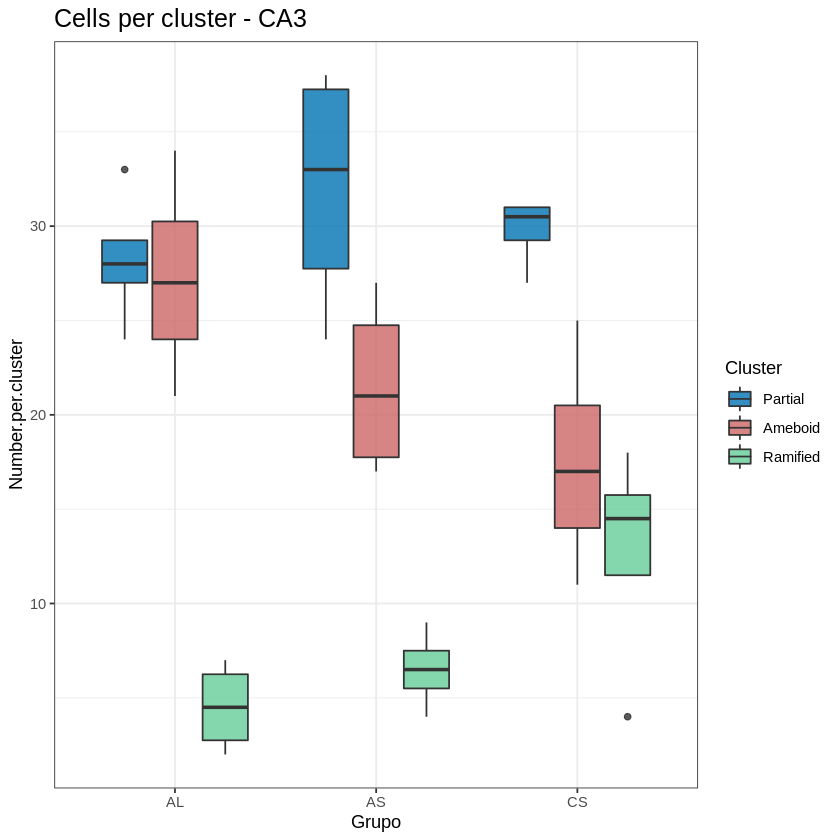

In [8]:
# cluster number by experimental group

# ver diferença de box plot em CA3 filtrado e nao filtrado
# 01: não filtrado
box01 <- summary.cluster.CA3 %>% ggplot(aes(x = Grupo, y = Number.per.cluster, fill = Cluster)) + geom_boxplot(alpha =  0.8) +
                                 ggtitle(label = "Cells per cluster - CA3") + scale_fill_manual(name="Cluster", values=c("#0072B2","#CC6666","#66CC99"), 
                                                                                                        labels = c("Partial","Ameboid","Ramified")) + theme_bw() +
                                 theme(plot.title = element_text(size=15))
# 02: 
#box02 <- f.summary.cluster.CA3 %>% ggplot(aes(x = Grupo, y = Number.per.cluster, fill = Cluster)) + geom_boxplot() +
#                                   ggtitle(label = "filtrado")

box01


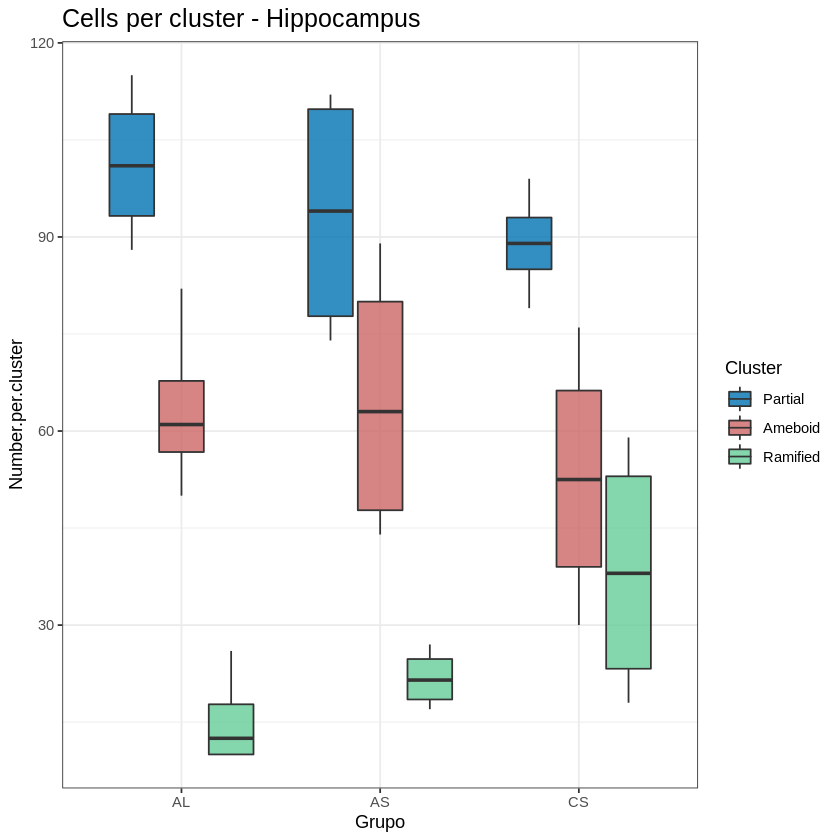

In [9]:
box.hip <- summary.cluster.all %>% ggplot(aes(x = Grupo, y = Number.per.cluster, fill = Cluster)) + geom_boxplot(alpha =  0.8) +
                                 ggtitle(label = "Cells per cluster - Hippocampus") + scale_fill_manual(name="Cluster", values=c("#0072B2","#CC6666","#66CC99"), 
                                                                                                        labels = c("Partial","Ameboid","Ramified")) + theme_bw() +
                                 theme(plot.title = element_text(size=15))

box.hip

In [10]:
head(f.summary.cluster.CA3)

Grupo,Animal,Region,Cluster,Number.per.cluster
AL,AL1,CA3,1,21
AL,AL1,CA3,2,30
AL,AL1,CA3,3,2
AL,AL2,CA3,1,30
AL,AL2,CA3,2,14
AL,AL2,CA3,3,6


### Session Info

In [11]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Linux Mint 20.2

Matrix products: default
BLAS/LAPACK: /home/caio/miniconda3/envs/r-jupyter/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=pt_BR.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=pt_BR.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=pt_BR.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] scales_1.0.0      plyr_1.8.4        svglite_2.0.0     dendextend_1.15.1
 [5] forcats_0.4.0     stringr_1.4.0     dplyr_1.0.7       purrr_0.3.4      
 [9] readr_1.3.1       tidyr_1.1.3       tibble_3.1.4      ggplot2_3.3.5    
[13] tidyverse_1.2.1  

loaded via a namespace (and not attach